In [1]:
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import pandas
import numpy
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def predict(model_name, data_name, num_iterations=-1):
    !../../LightGBM/lightgbm input_model=$model_name task=prediction data=$data_name output_result="temp.txt" num_iteration_predict=$num_iterations >> null
    predictions = pandas.read_csv("temp.txt", header=None)
    return predictions

def staged_predict(model_name, data_name, n_iterations=500, step=10):
    for i in range(1, n_iterations + 1, step):
        yield predict(model_name, data_name, num_iterations=i)
        
from collections import OrderedDict
def compute_auc_qualities(models, data, y, step=10):
    Qualities = OrderedDict()
    for name, model in models.items():
        stops = []
        quals = []
        for iteration, pred in zip(range(1, 501, step), staged_predict(model, data, n_iterations=500, step=step)):
            stops.append(iteration)
            quals.append(roc_auc_score(y, pred))
        Qualities[name] = [stops, quals]
    return Qualities

In [58]:
def read_quality(log_files, score="auc"):
    Qualities = OrderedDict()
    for name, log_file in log_files.items():
        quality = []
        stops = []
        training_time = 0.
        with open(log_file, "r") as f:
            for line in f.readlines():
                if "Iteration:" in line:
                    part = line.split("Iteration:")[1].split(",")
                    stops.append(int(part[0]))
                    assert score in part[1], "Haven't quality"
                    quality.append(float(part[1].split(": ")[-1]))
                if "seconds elapsed" in line:
                    training_time = line.split(" ")[2]
        Qualities[name] = [stops, quality]
        print "{:15} max: {:8} last: {:8}".format(name, numpy.max(quality), quality[-1]), 
        print "training time: {:8}".format(training_time)
    return Qualities

# Higgs dataset

In [59]:
# true_answers_higgs = pandas.read_csv("../data/higgs.test", usecols=[0], header=None, sep=' ')

In [64]:
models = dict(gbm="./models/higgs_gbm.txt", InfiniteBoost="./models/higgs_inf.txt")
log_files = dict(gbm="./lightgbm_higgs_accuracy.log", InfiniteBoost="./infinite_higgs_accuracy.log")
# Qualities = compute_auc_qualities(models, "../data/higgs.test", true_answers_higgs)
Qualities = read_quality(log_files)

gbm             max: 0.837472 last: 0.837442 training time: 438.027255
InfiniteBoost   max:  0.83636 last: 0.836357 training time: 410.025698


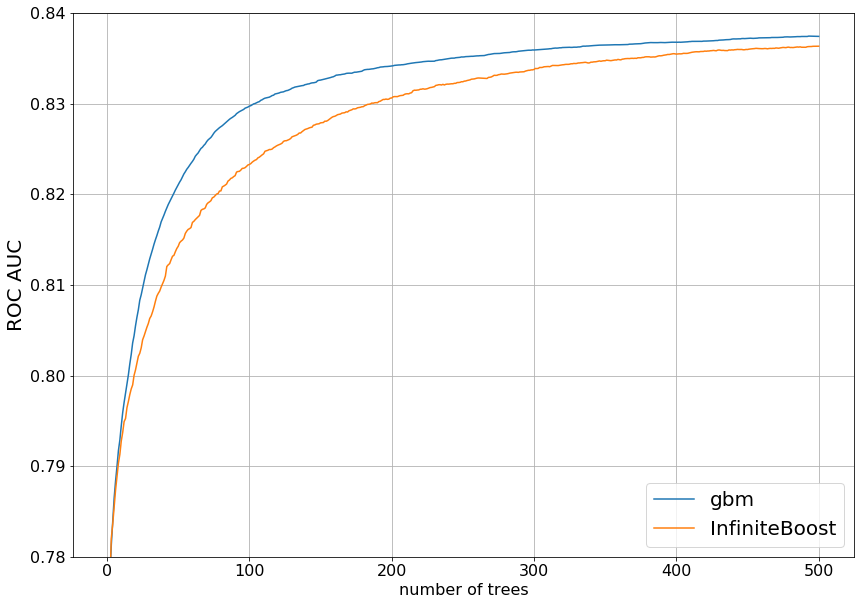

In [66]:
plt.figure(figsize=[14, 10])
for name, [stops, quals] in Qualities.items():
    plt.plot(stops, quals, label=name)

plt.xlabel('number of trees', fontsize=16)
plt.ylabel('ROC AUC', fontsize=20)
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

plt.ylim(0.78, 0.84)
plt.grid()
plt.legend(loc='lower right', fontsize=20)
plt.savefig('./plots/rocauc_higgs.pdf', bbox_inches='tight')